In [1]:
#Scenario 2: bistable state
#2.1.a: short simulation duration, constant target
#2.1.b: long simulation duration, constant target
#2.2.a: short simulation duration, sin target
#2.2.b: long simulation duration, sin target

In [1]:
# change to the root directory of the project
import os
if os.getcwd().split(os.sep)[-1] == "examples":
    os.chdir('..')
    
path = os.getcwd()
import sys
if path not in sys.path:
    sys.path.append(path)
    
# This will reload all imports as soon as the code changes
%load_ext autoreload
%autoreload 2    

import matplotlib.pyplot as plt
import numpy as np
#import testing

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# Let's import the aln model
from neurolib.models.aln import ALNModel

# Some useful functions are provided here
import neurolib.utils.functions as func

aln = ALNModel()

In [3]:
def plot_rate(model, control_, target_ = None):
    aln.run( control = control_ )
    time = model['t']

    fig, ax = plt.subplots()

    ax.plot(time, model['rates_exc'].T, lw=2, c='k', label='Exc activity')
    ax.set_xlabel("t [ms]")
    ax.set_ylabel("Rate [Hz]")
    ax.set_xlim([0,model.params['duration']])
    
    if type(target_) != type(None):
        ax.plot(time, target_[0,0,:], lw=2, c='yellow', label='Target')

    #ax2 = ax.twinx()
    #ax2.plot(time, control_[0,0,:]/5., lw=1, c='red', label='Exc control')
    #ax2.plot(time, control_[0,1,:]/5., lw=1, c='blue', label='Inh control')
    #ax2.set_xlabel("t [ms]")
    #ax2.set_ylabel("Control current [nA]")

    plt.legend()
    plt.show()

bistable state


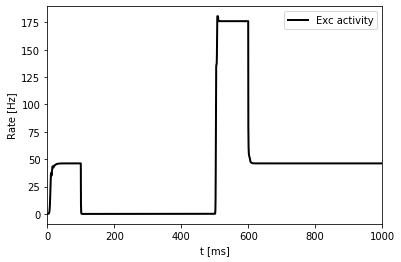

In [4]:
#initialize model

def set_aln_init_zero():
    N = aln.params.N
    aln.params.mufe_init = 0 * np.random.uniform(0, 1, (N,))  # mV/ms
    aln.params.mufi_init = 0 * np.random.uniform(0, 1, (N,))  # mV/ms
    aln.params.seem_init = 0. * np.random.uniform(0, 1, (N,))
    aln.params.seim_init = 0. * np.random.uniform(0, 1, (N,))
    aln.params.seev_init = 0. * np.random.uniform(0, 1, (N,))
    aln.params.seiv_init = 0. * np.random.uniform(0, 1, (N,))
    aln.params.siim_init = 0. * np.random.uniform(0, 1, (N,))
    aln.params.siem_init = 0. * np.random.uniform(0, 1, (N,))
    aln.params.siiv_init = 0. * np.random.uniform(0, 1, (N,))
    aln.params.siev_init = 0. * np.random.uniform(0, 1, (N,))
    aln.params.rates_exc_init = 0. * np.random.uniform(0, 1, (N, 1))
    aln.params.rates_inh_init = 0. * np.random.uniform(0, 1, (N, 1))
    aln.params.IA_init = 0.0 * np.zeros((N, 1))  # pA
    aln.params.mue_ou = 0. * np.random.uniform(0, 1, (N,))
    aln.params.mui_ou = 0. * np.random.uniform(0, 1, (N,))

# reads final state of model dynamics
# set before simulation such that system begins in stable state
def read_state():
    init_state_vars = np.zeros(( len(state_vars) ))
    for j in range(len(state_vars)):
        if aln.state[state_vars[j]].size == 1:
            init_state_vars[j] = aln.state[state_vars[j]][0]
        else:
            init_state_vars[j] = aln.state[state_vars[j]][0,-1]
    return init_state_vars
    
aln = ALNModel()
set_aln_init_zero()
aln.params.a = 0. # no adaptation
aln.params.b = 0. # no adaptation
aln.params.ext_exc_current = 0.
aln.params.ext_inh_current = 0.
aln.params['duration'] = 1000. 

control0 = aln.getZeroControl()
control0[0,0,1000:2000] = 5.
control0[0,0,5000:6000] = -5.

state_vars = aln.state_vars

# bistable state
print("bistable state")
aln.params.mue_ext_mean = 0.5 * 5.
aln.params.mui_ext_mean = 0.5 * 5.
    
plot_rate(aln, -control0)
init_bi_up = read_state()

In [5]:
 # to set initial parameters
def setinit(init_vars_, model):
    
    for iv in range(len(model.init_vars)):
        for sv in range(len(model.state_vars)):
            if model.state_vars[sv] in model.init_vars[iv]:
                if model.params[model.init_vars[iv]].ndim == 2:
                    model.params[model.init_vars[iv]][0,:] = init_vars_[sv]
                else:
                    model.params[model.init_vars[iv]][0] = init_vars_[sv]

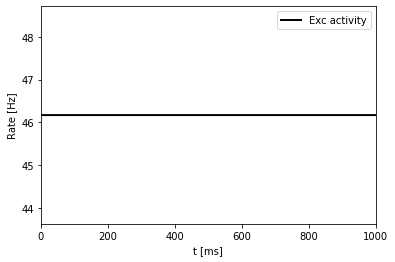

In [6]:
# fixed initialization should imply reproducibility, try also for other cases

aln = ALNModel()
set_aln_init_zero()
aln.params.a = 0. # no adaptation
aln.params.b = 0. # no adaptation
aln.params.ext_exc_current = 0.
aln.params.ext_inh_current = 0.
aln.params['duration'] = 1000. 
aln.params.mue_ext_mean = 0.5 * 5.  # try also other cases parameters
aln.params.mui_ext_mean = 0.5 * 5.
setinit(init_bi_up, aln)

control0 = aln.getZeroControl()
plot_rate(aln, control0)

In [18]:
# set parameters
tol = 1e-12 # algorithm tolerance for convergence

start_step = 10. # start step of gradient descent

c_scheme = np.zeros(( 1,1 )) # coupling scheme, only relevant for networks
c_scheme[0,0] = 1. # coupling scheme, only relevant for networks
u_mat = np.identity(1) # control matrix
u_scheme = np.array([[1.]]) # control scheme

max_it = 1000 # maximum number of iterations

max_cntrl = [5., 5., 0., 0., 0., 0.] # maximum value of control current in input nodes (exc current, inh current, rates)
min_cntrl = [-5., -5., 0., 0., 0., 0.]

cgv_list = [None, "HS", "FR", "PR", "CD", "LS", "DY", "WYL", "HZ"] # different gradient descent methods
cgv = cgv_list[0]

In [11]:
# scenario 2.1.a
# const target, short sim time
dur = 20. # simulation duration
aln.params.duration = dur
setinit(init_bi_up, aln)

control0 = aln.getZeroControl()
control0[0,0,1000:2000] = 0.1

target_const = aln.getZeroTarget()
target_const[0,0,:] = 50

# oscillation should be somewhat realistic, so roughly like what we find in stable oscillatory states.
# One period is roughly 40ms
target_osc = aln.getZeroTarget()
x_osc = np.arange(0.,dur+aln.params.dt,aln.params.dt)
target_osc[0,0,:] = 25. + 25. * np.sin(0.2 * x_osc)

In [13]:
#scenario 2.1.a

max_it_ = 400
cost_list_21a = []
runtime_list_21a = []
termination_it_21a = []
best_control_list_21a = []

for cgv_tmp in cgv_list:
    setinit(init_bi_up, aln)
    bestControl, bestState, cost, runtime, gradient, adjoint, costnode = aln.A1(
        control0, target_const, c_scheme, u_mat, u_scheme, max_iteration_ = max_it, tolerance_ = tol,
        startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl, t_sim_ = dur,
        t_sim_pre_ = 0., t_sim_post_ = 0., CGVar = cgv_tmp, control_variables_ = [0],
        prec_variables_ = [0], transition_time_ = 0.25)
    
    best_control_list_21a.append(bestControl)
    cost_list_21a.append(cost)
    runtime_list_21a.append(runtime)
    
    for cost_ind in range(len(cost)):
        if cost[cost_ind] == 0.:
            termination_it_21a.append(cost_ind-1)
            break

ERROR:root:Not possible to set up initial conditions without sufficient simulation time before control


interpolate adjoint :  True True True


C:\Users\lenas\anaconda3\lib\site-packages\numba\core\ir_utils.py:2031: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'max_control_' of function 'setmaxcontrol'.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "..\..\neurolib\neurolib\utils\func_optimize.py", line 132:
@numba.njit
def setmaxcontrol(n_control_vars, control_, max_control_, min_control_):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))
C:\Users\lenas\anaconda3\lib\site-packages\numba\core\ir_utils.py:2031: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'min_control_' of function 'setmaxcontrol'.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-lis

set default params
RUN  0 , total integrated cost =  109.98729061000056
Gradient descend method:  None
RUN  1 , total integrated cost =  7.907513535535011
RUN  2 , total integrated cost =  1.933215157955427
RUN  3 , total integrated cost =  1.1495308192473217
RUN  4 , total integrated cost =  0.8742230936090719
RUN  5 , total integrated cost =  0.7308211326174141
RUN  6 , total integrated cost =  0.6683205197334354
RUN  7 , total integrated cost =  0.6233393007759418
RUN  8 , total integrated cost =  0.6010946782878028
RUN  9 , total integrated cost =  0.5807366063490286
RUN  10 , total integrated cost =  0.5696733405960114
RUN  11 , total integrated cost =  0.556543137414625
RUN  12 , total integrated cost =  0.5494327460924838
RUN  13 , total integrated cost =  0.5375355060658842
RUN  14 , total integrated cost =  0.5320090492538294
RUN  15 , total integrated cost =  0.5296941650535796
RUN  16 , total integrated cost =  0.5268230112182659
RUN  17 , total integrated cost =  0.52640953

ERROR:root:Not possible to set up initial conditions without sufficient simulation time before control


interpolate adjoint :  True True True
RUN  0 , total integrated cost =  109.98729061000056
Gradient descend method:  HS
RUN  1 , total integrated cost =  7.907513535535011
RUN  2 , total integrated cost =  1.5392112101480253
RUN  3 , total integrated cost =  0.8664073424331706
RUN  4 , total integrated cost =  0.6794370313811149
RUN  5 , total integrated cost =  0.6007025523593355
RUN  6 , total integrated cost =  0.5612988768802143
RUN  7 , total integrated cost =  0.5452221554167803
RUN  8 , total integrated cost =  0.533193449071542
RUN  9 , total integrated cost =  0.528267491346774
RUN  10 , total integrated cost =  0.5248879823388818
RUN  11 , total integrated cost =  0.5233315634302258
RUN  12 , total integrated cost =  0.5221964115024489
RUN  13 , total integrated cost =  0.520396079809939
RUN  14 , total integrated cost =  0.5196303285634855
RUN  15 , total integrated cost =  0.5191078391712746
RUN  16 , total integrated cost =  0.5175112238382547
RUN  17 , total integrated co

ERROR:root:Not possible to set up initial conditions without sufficient simulation time before control


RUN  19 , total integrated cost =  0.5165181014533028
RUN  20 , total integrated cost =  0.5165181014533027
Control only changes marginally.
RUN  20 , total integrated cost =  0.5165181014533027
Improved over  20  iterations in  0.21952419999999506  seconds by  99.53038383017834  percent.
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  109.98729061000056
Gradient descend method:  FR
RUN  1 , total integrated cost =  7.907513535535011
RUN  2 , total integrated cost =  1.5520942556030157
RUN  3 , total integrated cost =  0.8945528087461094
RUN  4 , total integrated cost =  0.6802328413258303
RUN  5 , total integrated cost =  0.5934363980731421
RUN  6 , total integrated cost =  0.5590417014814578
RUN  7 , total integrated cost =  0.5410584189879768
RUN  8 , total integrated cost =  0.5318131742983688
RUN  9 , total integrated cost =  0.5268579492995851
RUN  10 , total integrated cost =  0.5240313010683386
RUN  11 , total integrated cost =  0.5224999492946493
RUN  1

ERROR:root:Not possible to set up initial conditions without sufficient simulation time before control


RUN  1000 , total integrated cost =  0.5158049330901516
RUN  1000 , total integrated cost =  0.5158049330901516
Improved over  1000  iterations in  8.990261000000004  seconds by  99.53103223997114  percent.
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  109.98729061000056
Gradient descend method:  PR
RUN  1 , total integrated cost =  7.907513535535011
RUN  2 , total integrated cost =  1.5495383595280923
RUN  3 , total integrated cost =  0.8854643310839356
RUN  4 , total integrated cost =  0.6859686351135965
RUN  5 , total integrated cost =  0.6018529161196153
RUN  6 , total integrated cost =  0.5644409835088927
RUN  7 , total integrated cost =  0.5475322826543452
RUN  8 , total integrated cost =  0.5357109887406261
RUN  9 , total integrated cost =  0.531196608644862
RUN  10 , total integrated cost =  0.5267421370867799
RUN  11 , total integrated cost =  0.5239411008017613
RUN  12 , total integrated cost =  0.5223741999762666
RUN  13 , total integrated cost =  0

ERROR:root:Not possible to set up initial conditions without sufficient simulation time before control


RUN  18 , total integrated cost =  0.518169229919449
RUN  19 , total integrated cost =  0.5162342228958262
RUN  20 , total integrated cost =  0.515884927975663
Control only changes marginally.
RUN  24 , total integrated cost =  0.5158829611504954
Improved over  24  iterations in  0.2676886999999937  seconds by  99.5309612971741  percent.
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  109.98729061000056
Gradient descend method:  CD
RUN  1 , total integrated cost =  7.907513535535011
RUN  2 , total integrated cost =  1.5520942556030157
RUN  3 , total integrated cost =  0.8951889759987237
RUN  4 , total integrated cost =  0.6793361127411506
RUN  5 , total integrated cost =  0.5943005881462937
RUN  6 , total integrated cost =  0.5650916197423586
RUN  7 , total integrated cost =  0.5484568676538919
RUN  8 , total integrated cost =  0.54193758269107
RUN  9 , total integrated cost =  0.5357339636645392
RUN  10 , total integrated cost =  0.5319745187602385
RUN  11 , to

ERROR:root:Not possible to set up initial conditions without sufficient simulation time before control


RUN  40 , total integrated cost =  0.5198568373657035
Control only changes marginally.
RUN  48 , total integrated cost =  0.5159752481698214
Improved over  48  iterations in  0.49302869999999643  seconds by  99.5308773901892  percent.
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  109.98729061000056
Gradient descend method:  LS
RUN  1 , total integrated cost =  7.907513535535011
RUN  2 , total integrated cost =  1.5495383595280923
RUN  3 , total integrated cost =  0.8979007649971074
RUN  4 , total integrated cost =  0.702395275790999
RUN  5 , total integrated cost =  0.6014763637055611
RUN  6 , total integrated cost =  0.5708629848534053
RUN  7 , total integrated cost =  0.551987838820434
RUN  8 , total integrated cost =  0.5370234707937634
RUN  9 , total integrated cost =  0.531992158097937
RUN  10 , total integrated cost =  0.526637708541109
RUN  11 , total integrated cost =  0.5242984735330027
RUN  12 , total integrated cost =  0.5222607346518718
RUN  13 , t

ERROR:root:Not possible to set up initial conditions without sufficient simulation time before control


RUN  25 , total integrated cost =  0.5153950857436655
Improved over  25  iterations in  0.2856431000000015  seconds by  99.53140487152176  percent.
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  109.98729061000056
Gradient descend method:  DY
RUN  1 , total integrated cost =  7.907513535535011
RUN  2 , total integrated cost =  1.5571787620664173
RUN  3 , total integrated cost =  0.8982254546080407
RUN  4 , total integrated cost =  0.6834219374708941
RUN  5 , total integrated cost =  0.5957435403835475
RUN  6 , total integrated cost =  0.5563854998399971
RUN  7 , total integrated cost =  0.5377031944260352
RUN  8 , total integrated cost =  0.5300073794505284
RUN  9 , total integrated cost =  0.525586811929703
RUN  10 , total integrated cost =  0.5235318430293008
RUN  11 , total integrated cost =  0.5212261671753914
RUN  12 , total integrated cost =  0.5200781664791315
RUN  13 , total integrated cost =  0.519222165354075
RUN  14 , total integrated cost =  0.51730

ERROR:root:Not possible to set up initial conditions without sufficient simulation time before control


RUN  18 , total integrated cost =  0.5155526690483682
RUN  19 , total integrated cost =  0.5154935106202495
RUN  20 , total integrated cost =  0.5154000775052967
Control only changes marginally.
RUN  22 , total integrated cost =  0.5153440327436435
Improved over  22  iterations in  0.24488510000000474  seconds by  99.531451288703  percent.
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  109.98729061000056
Gradient descend method:  WYL
RUN  1 , total integrated cost =  7.907513535535011
RUN  2 , total integrated cost =  1.5206362973870662
RUN  3 , total integrated cost =  0.8905287514342253
RUN  4 , total integrated cost =  0.6735203237549866
RUN  5 , total integrated cost =  0.5958812097439158
RUN  6 , total integrated cost =  0.5624109789120595
RUN  7 , total integrated cost =  0.5385819246647173
RUN  8 , total integrated cost =  0.5312056281465274
RUN  9 , total integrated cost =  0.5243172479015963
RUN  10 , total integrated cost =  0.5234296887248617


D:\Promotion\neurolib\neurolib\utils\func_optimize.py:478: RuntimeWarning: invalid value encountered in double_scalars
  numerator = np.dot( grad1_[n,v,:], grad1_[n,v,:] - grad0_[n,v,:] * ( g1abs / g0abs ) )


RUN  11 , total integrated cost =  0.5227918152787413
RUN  12 , total integrated cost =  0.5204034254139491
RUN  13 , total integrated cost =  0.5203013792242211
RUN  14 , total integrated cost =  0.5201196658221369
RUN  15 , total integrated cost =  0.5200279745550923
RUN  16 , total integrated cost =  0.5197554673343435
RUN  17 , total integrated cost =  0.5171002977365449
RUN  18 , total integrated cost =  0.5170492552834098
RUN  19 , total integrated cost =  0.5161686014295809
RUN  20 , total integrated cost =  0.5161652898793816
RUN  30 , total integrated cost =  0.5160934228866966


ERROR:root:Not possible to set up initial conditions without sufficient simulation time before control


Control only changes marginally.
RUN  31 , total integrated cost =  0.5160934228866959
Improved over  31  iterations in  0.33482690000001014  seconds by  99.53076994621433  percent.
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  109.98729061000056
Gradient descend method:  HZ
RUN  1 , total integrated cost =  7.907513535535011
RUN  2 , total integrated cost =  1.933437268781456
RUN  3 , total integrated cost =  1.1259944516183529
RUN  4 , total integrated cost =  0.8621596186273067
RUN  5 , total integrated cost =  0.7269627431631309
RUN  6 , total integrated cost =  0.6674766185822041
RUN  7 , total integrated cost =  0.6231896724146577
RUN  8 , total integrated cost =  0.6004805231891919
RUN  9 , total integrated cost =  0.5789073850863272
RUN  10 , total integrated cost =  0.5674587804384543
RUN  11 , total integrated cost =  0.5527290295504503
RUN  12 , total integrated cost =  0.5444957092547846
RUN  13 , total integrated cost =  0.5256342611602659
RUN  14

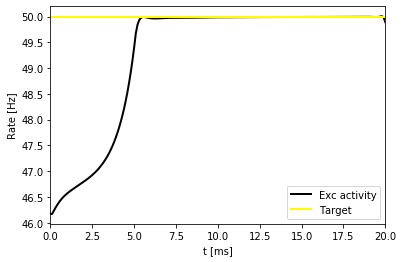

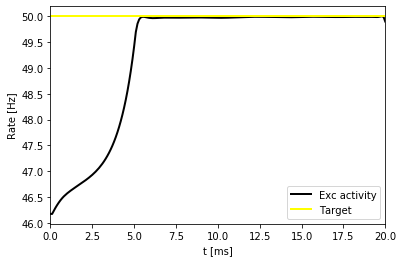

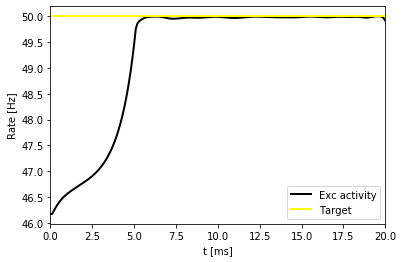

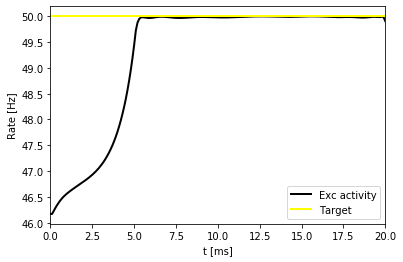

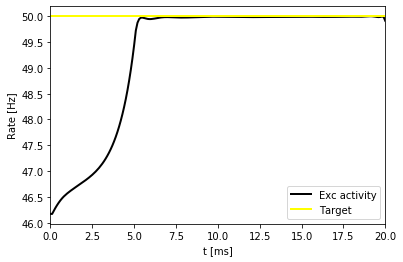

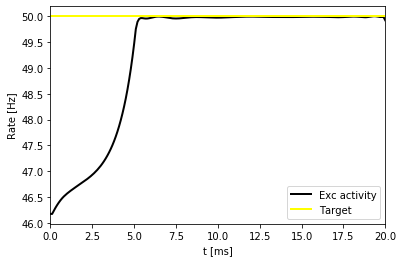

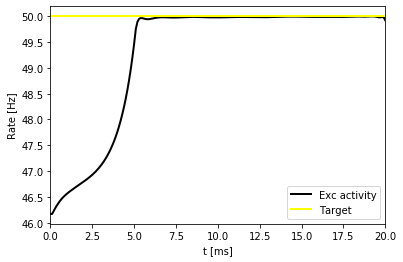

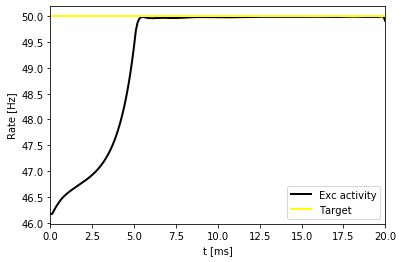

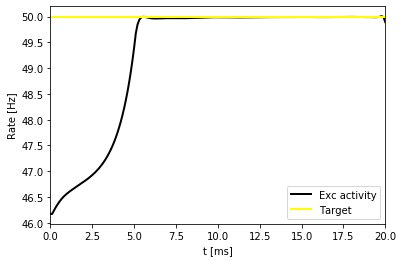

In [14]:
for cgv_ind in range(len(cgv_list)):
    plot_rate(aln, best_control_list_21a[cgv_ind], target_const)

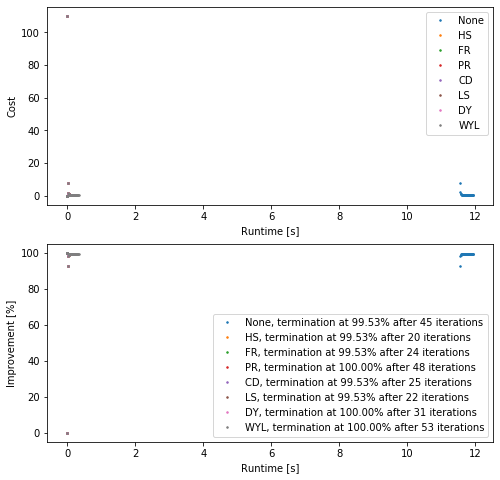

In [15]:
marker_ = '.'
markersize_ = 3
linestyle_ = ''

fig, ax = plt.subplots(2, figsize=(8,8))

for i in range(len(termination_it_21a)):
    ax[0].plot(runtime_list_21a[i][:termination_it_21a[i]], cost_list_21a[i][:termination_it_21a[i]], marker=marker_,
             markersize = markersize_, linestyle=linestyle_, label = str(cgv_list[i]))
    performance = []
    for j in range(termination_it_21a[i]):
        performance.append( 100. * ( cost_list_21a[i][0] - cost_list_21a[i][j]) / cost_list_21a[i][0] ) 
    ax[1].plot(runtime_list_21a[i][:termination_it_21a[i]], performance, marker=marker_,
            markersize = markersize_, linestyle=linestyle_,
            label = str(cgv_list[i]) + ', termination at {:.2f}'.format(performance[-1]) + '% after ' + str(termination_it_21a[i]) + ' iterations' )
ax[0].legend()
ax[0].set_xlabel('Runtime [s]')
ax[0].set_ylabel('Cost')
#ax[0].title.set_text('Cost per runtime')
ax[1].legend()
ax[1].set_xlabel('Runtime [s]')
ax[1].set_ylabel('Improvement [%]')
#ax[0].title.set_text('Cost per runtime')


plt.show()

In [20]:
#scenario 2.2.a

max_it_ = 400
cost_list_22a = []
runtime_list_22a = []
termination_it_22a = []
best_control_list_22a = []

for cgv_tmp in cgv_list:
    setinit(init_bi_up, aln)
    bestControl, bestState, cost, runtime, gradient, adjoint, costnode = aln.A1(
        control0, target_osc, c_scheme, u_mat, u_scheme, max_iteration_ = max_it, tolerance_ = tol,
        startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl, t_sim_ = dur,
        t_sim_pre_ = 0., t_sim_post_ = 0., CGVar = cgv_tmp, control_variables_ = [0],
        prec_variables_ = [0], transition_time_ = 0.25)
    
    best_control_list_22a.append(bestControl)
    cost_list_22a.append(cost)
    runtime_list_22a.append(runtime)
    
    for cost_ind in range(len(cost)):
        if cost[cost_ind] == 0.:
            termination_it_22a.append(cost_ind-1)
            break

ERROR:root:Not possible to set up initial conditions without sufficient simulation time before control


interpolate adjoint :  True True True
RUN  0 , total integrated cost =  2554.640293796091
Gradient descend method:  None
RUN  1 , total integrated cost =  104.72433207753711
 max iteration reached, step size =  4.773338067968132e-152
RUN  2 , total integrated cost =  104.72433207753711
 max iteration reached, step size =  4.773338067968132e-152
RUN  3 , total integrated cost =  nan
 max iteration reached, step size =  4.773338067968132e-152
RUN  4 , total integrated cost =  nan
 max iteration reached, step size =  4.773338067968132e-152
RUN  5 , total integrated cost =  nan
 max iteration reached, step size =  4.773338067968132e-152
RUN  6 , total integrated cost =  nan
 max iteration reached, step size =  4.773338067968132e-152
RUN  7 , total integrated cost =  nan
 max iteration reached, step size =  4.773338067968132e-152
RUN  8 , total integrated cost =  nan


KeyboardInterrupt: 

In [ ]:
for cgv_ind in range(len(cgv_list)):
    plot_rate(aln, best_control_list_22a[cgv_ind], target_osc)

In [ ]:
marker_ = '.'
markersize_ = 3
linestyle_ = ''

fig, ax = plt.subplots(2, figsize=(8,8))

for i in range(len(termination_it_22a)):
    ax[0].plot(runtime_list_22a[i][:termination_it_22a[i]], cost_list_22a[i][:termination_it_22a[i]], marker=marker_,
             markersize = markersize_, linestyle=linestyle_, label = str(cgv_list[i]))
    performance = []
    for j in range(termination_it_22a[i]):
        performance.append( 100. * ( cost_list_22a[i][0] - cost_list_22a[i][j]) / cost_list_22a[i][0] ) 
    ax[1].plot(runtime_list_22a[i][:termination_it_22a[i]], performance, marker=marker_,
            markersize = markersize_, linestyle=linestyle_,
            label = str(cgv_list[i]) + ', termination at {:.2f}'.format(performance[-1]) + '% after ' + str(termination_it_22a[i]) + ' iterations' )
ax[0].legend()
ax[0].set_xlabel('Runtime [s]')
ax[0].set_ylabel('Cost')
#ax[0].title.set_text('Cost per runtime')
ax[1].legend()
ax[1].set_xlabel('Runtime [s]')
ax[1].set_ylabel('Improvement [%]')
#ax[0].title.set_text('Cost per runtime')


plt.show()